In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import Counter


In [8]:
files = os.listdir('predictions')
print(files)

['predictions_seed1_Diffusion_bool_ABC_25epoch.csv', 'predictions_seed3_Diffusion_bool_B_25epoch.csv', 'predictions_seed1_Diffusion_bool_ABCD_25epoch.csv', 'predictions_seed2_Diffusion_bool_mofkey_25epoch.csv', 'predictions_seed3_Diffusion_bool_mofkey_25epoch.csv', 'predictions_seed2_Diffusion_bool_B_25epoch.csv', 'predictions_seed2_Diffusion_bool_ABCD_25epoch.csv', 'predictions_seed1_Diffusion_bool_mofkey_25epoch.csv', 'predictions_seed3_Diffusion_bool_AB_25epoch.csv', 'predictions_seed1_Diffusion_bool_A_25epoch.csv', 'predictions_seed2_Diffusion_bool_AB_25epoch.csv', 'predictions_seed1_Diffusion_bool_AB_25epoch.csv', 'predictions_seed3_Diffusion_bool_A_25epoch.csv', 'predictions_seed2_Diffusion_bool_A_25epoch.csv', 'predictions_seed1_Diffusion_bool_B_25epoch.csv', 'predictions_seed2_Diffusion_bool_ABC_25epoch.csv', 'predictions_seed3_Diffusion_bool_ABCD_25epoch.csv', 'predictions_seed3_Diffusion_bool_ABC_25epoch.csv']


In [9]:
def check_on_files(files:list):
    for file in files:
        df = pd.read_csv(file)
        for value in df['prediction']:
            if value not in [0,1, 999]:
                print(file)
                continue

In [10]:
def create_csv_df(folder):
    files = os.listdir(folder)
    files_path = [os.path.join(folder, i) for i in files]
    df = pd.DataFrame({'file':files_path})
    df['representation'] = [i.split('_bool_')[-1].split('_')[0] for i in files]
    df['seed'] = [i.split('_seed')[-1].split('_')[0] for i in files]
    df = df.sort_values(['seed', 'representation'])


    return df

csv_df = create_csv_df('predictions') 
check_on_files(csv_df['file'])

In [18]:
def calculate_accuracy(actual_labels, predicted_labels, rounding = 1):
    """
    Calculate accuracy manually without using sklearn.
    
    Parameters:
        actual_labels (list): List of actual labels.
        predicted_labels (list): List of predicted labels.
        
    Returns:
        float: Accuracy percentage.
    """
    if len(actual_labels) != len(predicted_labels):
        raise ValueError("Length of actual_labels and predicted_labels must be the same.")
    
    correct = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total = len(actual_labels)
    accuracy = correct / total * 100
    accuracy = round(accuracy, rounding)
    return accuracy

def get_csvs_seed(df, seed):
    return df.loc[df['seed'] == str(seed)]

def create_seed_overview(csv_df, seed):
    seed_df = get_csvs_seed(csv_df, seed)
    print(f'Analyzing seed {seed}. ({len(seed_df)} files)')
    for i, (_, row) in enumerate(seed_df.iterrows()):
        pred_df = pd.read_csv(row['file'])
        repres = list(pred_df.columns)[1]

        test_df = pred_df.loc[pred_df['partition'] == 'test']
        if i == 0:
            overview_df = pd.DataFrame({'structure': test_df['Unnamed: 0'],
                                        'true': test_df['Diffusion_bool']})
        
        overview_df[f'{repres}_pred'] = test_df['prediction']

    return overview_df

def analyse_seed(df:pd.DataFrame):
    perc_0, perc_1 = [], []
    for _, row in df.iterrows():
        pred_cols = [col for col in df.columns if col.endswith('_pred')]
        values = [row[col] for col in pred_cols]
        perc_0.append(values.count(0)/len(values))
        perc_1.append(values.count(1)/len(values))

    df['perc_0'] = perc_0
    df['perc_1'] = perc_1
    df['pred_same'] = [p in [0,1] for p in df['perc_0']]

    n_same = list(df['pred_same']).count(True)
    df_same_pred = df.loc[df['pred_same'] == True]
    df['pred_same_correct'] = [same == True and true == pred for same, true, pred in zip(df['pred_same'], df['true'], df[pred_cols[0]])]
    print(f'For {len(df_same_pred)} entries ({100 * (len(df_same_pred)/len(df))} %), all the {len(pred_cols)} predictions were the same')
    n_same_correct = list(df['pred_same_correct']).count(True)
    print(f'For these {len(df_same_pred)} predictions, {n_same_correct} were CORRECT')
    return df

def plot_analysis(df:pd.DataFrame):
    fig, ax = plt.subplots(1,1, figsize = (10, 10), tight_layout = True, sharex=True,
                           )

    color_map = 'Blues'

    pred_cols = [col for col in df.columns if col.endswith('_pred')]
    pred_cols_2 = ['true'] + pred_cols
    df_pred = df[pred_cols_2]

    a = df_pred.to_numpy()
    a = np.transpose(a)

    ax.imshow(a, 
              cmap = color_map
              )
    ax.set_yticks(np.arange(len(pred_cols_2)), labels=[col.split('_pred')[0] for col in pred_cols_2])


    sames = df.index[df['pred_same'] == True].tolist()
    sames_incorrect = df.index[(df['pred_same_correct'] == False) & (df['pred_same'] == True)].tolist()
    print(sames_incorrect)
    for same in sames:
        ax.vlines([same-0.5, same +0.5], -0.5,len(pred_cols_2)-0.5, colors = 'green', linewidth = 5)
    for incorrect in sames_incorrect:
        ax.vlines([incorrect-0.5, incorrect +0.5], -0.5,0.5, colors = 'red', linewidth = 5)
    ax.hlines(0.5, 0-0.5, len(df)-0.5, linewidth = 2, colors = 'maroon')

    n_same = dict(df['pred_same'].value_counts())[True]
    n_same_correct = dict(df['pred_same_correct'].value_counts())[True]
    ax.set_title(f'Same Predictions: {n_same} ({round(n_same/len(df) *100, 2) }%)\nAccuracy Same Predictions: {n_same_correct} ({round(n_same_correct/n_same *100, 2) }%)')
    
    ax.text(len(df) + 0.25, -0.5, 'Acc.', fontsize=10)

    for i, col in enumerate(pred_cols):
        accuracy = calculate_accuracy(list(df['true']), list(df[col]))
        ax.text(len(df) + 0.25, i +1.5, str(accuracy), fontsize=10)



Analyzing seed 1. (6 files)
For 14 entries (28.000000000000004 %), all the 6 predictions were the same
For these 14 predictions, 13 were CORRECT
[32]
Analyzing seed 2. (6 files)
For 12 entries (24.0 %), all the 6 predictions were the same
For these 12 predictions, 10 were CORRECT
[25, 28]
Analyzing seed 3. (6 files)
For 7 entries (14.000000000000002 %), all the 6 predictions were the same
For these 7 predictions, 7 were CORRECT
[]


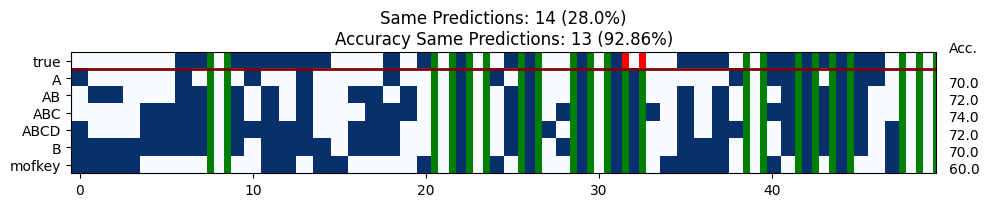

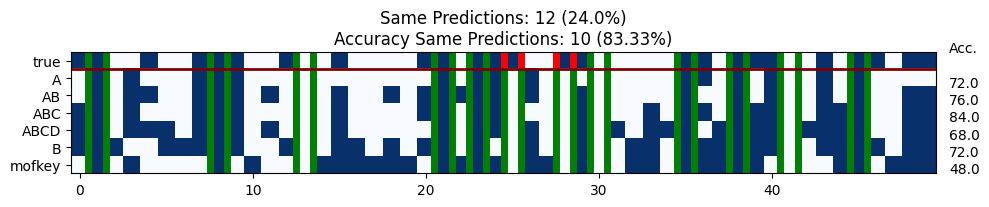

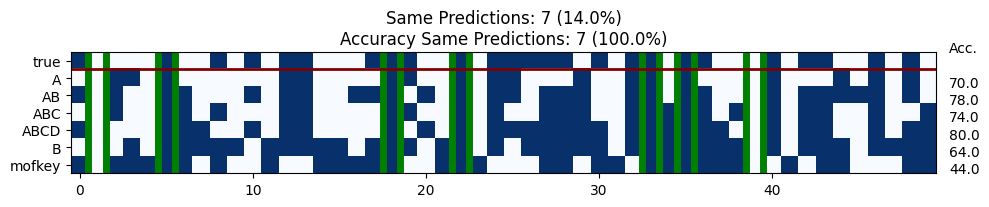

In [19]:
for seed in [1, 2, 3]:
    df = create_seed_overview(csv_df, seed)
    df = analyse_seed(df)
    df.reset_index(drop=True, inplace=True)
    plot_analysis(df)
    

In [13]:
df

,structure,true,A_pred,AB_pred,ABC_pred,ABCD_pred,B_pred,mofkey_pred,perc_0,perc_1,pred_same,pred_same_correct
0,558,1,0,1,0,1,0,1,0.500000,0.500000,False,False
1,572,0,0,0,0,0,0,0,1.000000,0.000000,True,True
2,441,0,1,1,1,0,0,1,0.333333,0.666667,False,False
3,39,0,1,0,0,0,1,1,0.500000,0.500000,False,False
4,356,0,0,0,0,0,0,1,0.833333,0.166667,False,False
5,348,1,1,1,1,1,1,1,0.000000,1.000000,True,True
6,598,0,0,1,1,1,1,1,0.166667,0.833333,False,False
7,82,0,0,0,0,1,1,0,0.666667,0.333333,False,False
8,551,1,0,0,1,0,1,1,0.500000,0.500000,False,False
9,323,0,0,0,0,0,1,0,0.833333,0.166667,False,False
